# DigDeeper: An automated research article tool

Researchers spend 23% of total work time reading around 22 scholarly articles per month. 
Reasons for reading scholarly research articles can be varied , including updating onself with research progress in their field, get ideas for research and garner support for research views and results.

So how to find the scholarly article to read.

Tradional ways:
1. Search using keywords
2. Scan the current and previous issues of the top journals in their field.
3. Article recommendations from colleagues
4. Use other tools such as [CONNECTED PAPERS](https://www.connectedpapers.com/)

The traditional ways often rely on a single article for generating reading recommendations, or recommend a single article,
or rely on just a few keywords. Often these solution may not be useful for researchers who have an existing list of articles
they have read in this field, but are looking for related articles. So DigDepeer does exactly that, based on information extracted from a few exisiting research articles, it recommends and ranks articles that best match the current set of existing research articles on what you should be reading next.

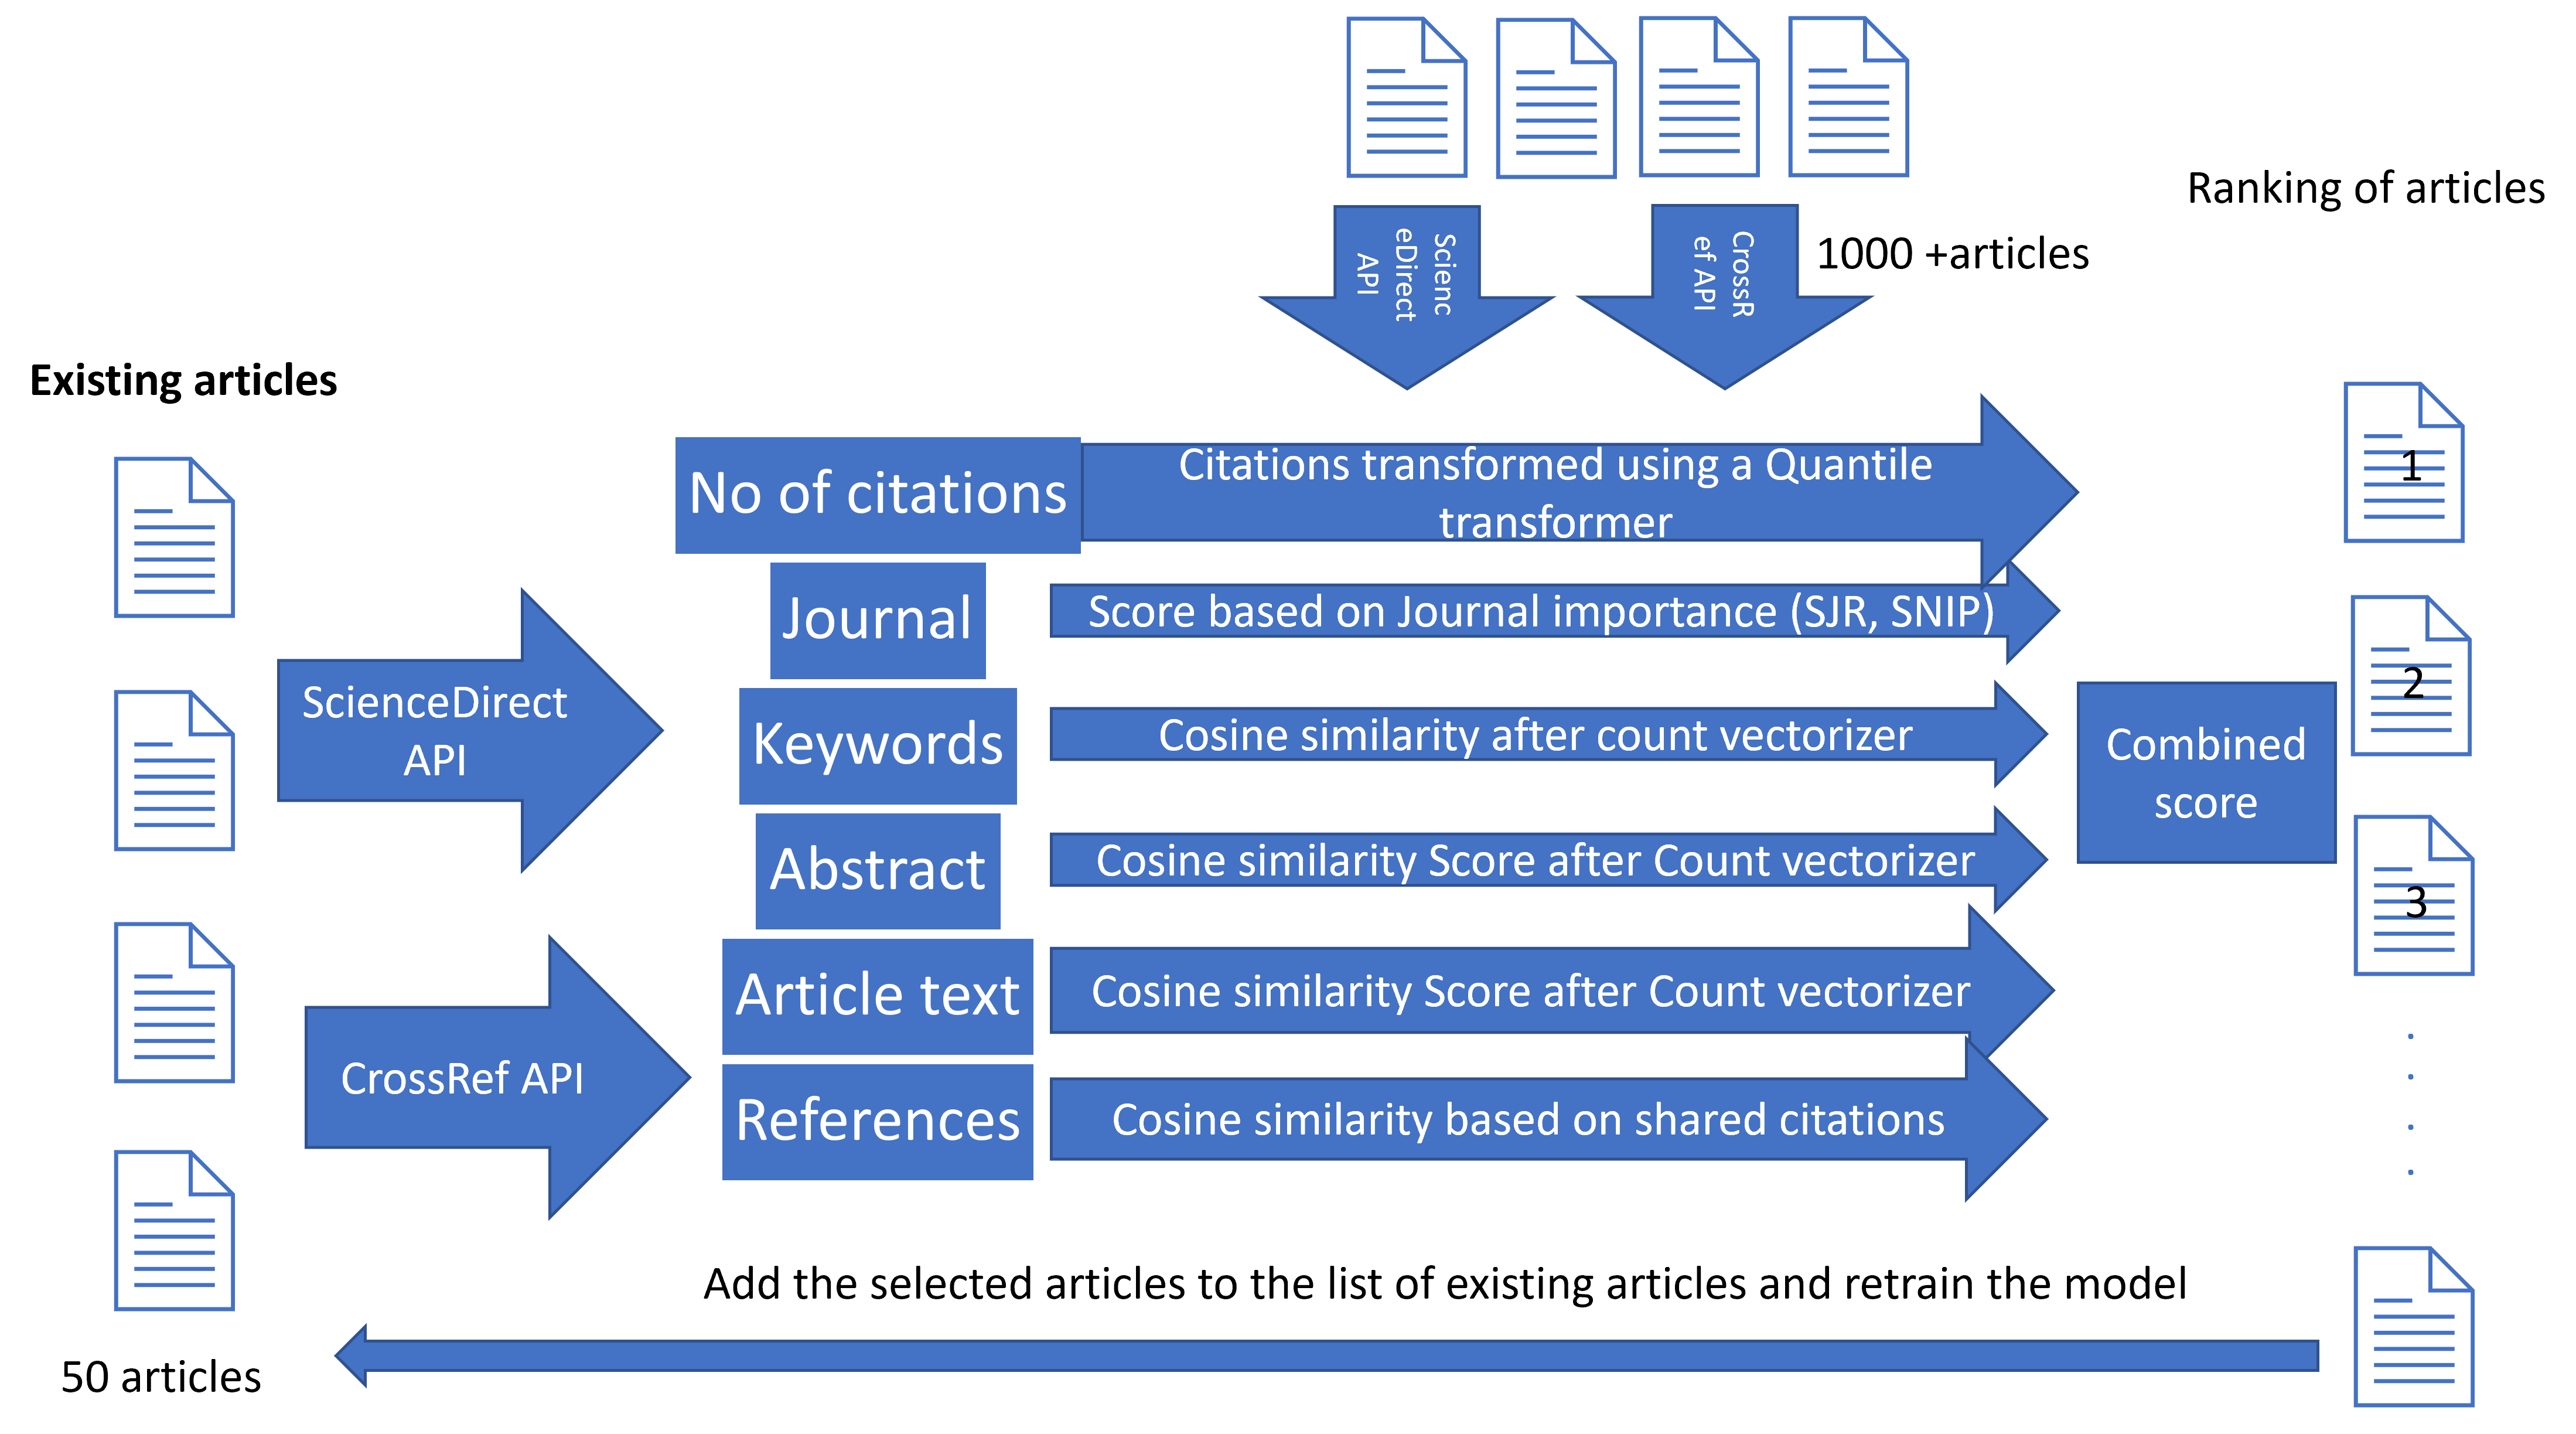

I will be using my research area functional near infrared spectroscopy (fNIRS). More information about the brain imaging method can be found here: https://en.wikipedia.org/wiki/Functional_near-infrared_spectroscopy)

In [661]:
# Install Spacy and download English transformers pipeline
#!pip install -U pip setuptools wheel
#!pip install -U spacy
#!python -m spacy download en_core_web_trf
import spacy
nlp = spacy.load("en_core_web_trf")

In [860]:
# For getting the research articles we use a python module Elapsy which provides a more user friendly wrapper 
# to Elseiver's API

from elsapy.elsclient import ElsClient
from elsapy.elsprofile import ElsAuthor, ElsAffil
from elsapy.elsdoc import FullDoc, AbsDoc
from elsapy.elssearch import ElsSearch
    
## Load configuration
con_file = open("config.json")
config = json.load(con_file)
con_file.close()

In [901]:
# Load and import necessary modules
import pandas as pd
import numpy as np
import pickle
import glob
import re
import requests
import json
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [902]:
# lets set the folder for my articles 
article_folder = "C:/Users/prady/Downloads/TDI/Capstone/data/MyfNIRS"

In [903]:
## Initialize client
client = ElsClient(config['apikey'])
client.local_dir = article_folder #Path  to the local dir that contains my fNIRS files

In [48]:
# Lets search for articles containing information about the search term fNIRS and 
# related to neuroimaging from Science direct from the years 2012-2022
doc_srch_fNIRS = ElsSearch("all(fNIRS) AND all(neuroimaging) AND date(2012-2022)",'sciencedirect')
doc_srch_fNIRS.execute(client, get_all = True)

In [49]:
# Print the output of the search result
print ("We were able to identify about", len(doc_srch_fNIRS.results), "results.")

We were able to identify about 1711 results.


In [ ]:
# Lets save the search results as pickle file so that we do not have to query again

# Open a file and use dump()
with open('fNIRS_Search_list.pkl', 'wb') as file:
    pickle.dump(doc_srch_fNIRS.results, file)

In [ ]:
# Lets read the search results file if needed
with open('fNIRS_Search_list.pkl', 'rb') as file:
    doc_srch_fNIRS_results = pickle.load(file)

len(doc_srch_fNIRS_results)

In [3]:
# Loop through the search results and extracting the full text of the articles in our search results
tot =0
for doc in range(len(doc_srch_fNIRS.results)):
    doi_doc = FullDoc(doi = doc_srch_fNIRS.results[doc]['prism:doi'])
    if doi_doc.read(client):
        #print ("doi_doc.title: ", doi_doc.title)
        doi_doc.write()
        tot=tot+1
print("We were able to get full text documents of", tot, "articles")

In [17]:
# Lets also find some fMRI articles which should be less relevant than fNIRS articles but more relevant than others
client.local_dir = "C:/Users/prady/Downloads/TDI/Capstone/data/fMRI"
doc_srch_fMRI = ElsSearch("all(fMRI) AND all(neuroimaging) AND date(2012-2022)",'sciencedirect')
doc_srch_fMRI.execute(client, get_all = True)
tot =0
for doc in range(200):
    if tot >=100:
        break
    doi_doc = FullDoc(doi = doc_srch_fMRI.results[doc]['prism:doi'])
    if doi_doc.read(client):
        #print ("doi_doc.title: ", doi_doc.title)
        doi_doc.write()
        tot=tot+1
print("We were able to get full text documents of", tot, "articles")

We were able to get full text documents of 100 articles


In [18]:
# Lets also find some psychology articles which should be less relevant than fNIRS and fMRI articles but more 
# relevant than others
client.local_dir = "C:/Users/prady/Downloads/TDI/Capstone/data/Psychology"
doc_srch_psy= ElsSearch("all(language development) AND date(2012-2022)",'sciencedirect')
doc_srch_psy.execute(client, get_all = True)
tot =0
for doc in range(200):
    if tot >=100:
        break
    doi_doc = FullDoc(doi = doc_srch_psy.results[doc]['prism:doi'])
    if doi_doc.read(client):
        #print ("doi_doc.title: ", doi_doc.title)
        doi_doc.write()
        tot=tot+1
print("We were able to get full text documents of", tot, "articles")

We were able to get full text documents of 100 articles


In [23]:
# Finally lets get some article in Geology. These should be the least relevant
client.local_dir = "C:/Users/prady/Downloads/TDI/Capstone/data/Geology"
doc_srch_geo= ElsSearch("all(Geology) AND date(2012-2022)",'sciencedirect')
doc_srch_geo.execute(client , get_all = True)
tot =0
for doc in range(200):
    if tot >= 100:
        break
    doi_doc = FullDoc(doi = doc_srch_geo.results[doc]['prism:doi'])
    if doi_doc.read(client):
        #print ("doi_doc.title: ", doi_doc.title)
        doi_doc.write()
        tot=tot+1
print("We were able to get full text documents of", tot, "articles")

We were able to get full text documents of 100 articles


In [731]:
from sklearn.base import BaseEstimator, TransformerMixin
# While I wanted to extract the references for each article using doi or an Elsevier's API query and the citation counts
# for each of my articles, my Key does not currently have access to the information. In future, I plan to implement it.

    
def extract_journal_metrics(issn):
# Extract SNIP and SJR which are metrics of a journal's reputation
    params={'issn':issn, 
            'apiKey': "", # Enter your own API Key 
            'field': 'SJR,SNIP',
            'view': 'STANDARD'}
    response = requests.get('http://api.elsevier.com/content/serial/title', params)
    resp_json = response.json()
    if ((resp_json['serial-metadata-response'].get('entry')) and ((resp_json['serial-metadata-response']['entry'][0]).get('SNIPList')) and
        ((resp_json['serial-metadata-response']['entry'][0]).get('SJRList'))):
        snip_df =  pd.DataFrame.from_dict(resp_json['serial-metadata-response']['entry'][0]['SNIPList']["SNIP"])
        snip_df['$'] = snip_df['$'].astype(float)
        snip_df['@year'] = pd.to_datetime(snip_df['@year']).dt.year 
        snip = snip_df.sort_values(by=['@year'] , ascending=False).loc[0, '$']
        sjr_df =  pd.DataFrame.from_dict(resp_json['serial-metadata-response']['entry'][0]['SJRList']["SJR"])
        sjr_df['$'] = sjr_df['$'].astype(float)
        sjr_df['@year'] = pd.to_datetime(sjr_df['@year']).dt.year 
        sjr = sjr_df.sort_values(by=['@year'] , ascending=False).loc[0, '$']
        return(snip, sjr)
    else:
        return(0,0)

def get_references (doi):
    # get the references and total citations for an article
    references = []
    refs =requests.get("http://api.crossref.org/works/"+doi)
    if (refs.ok):
        refs = refs.json()
        reflist = refs['message'].get('reference')
        if reflist:
            for ref in reflist:
                if (ref.get('DOI')):
                    references.append(ref['DOI'].lower())
        citations = refs['message']['is-referenced-by-count']
        return(citations, references) 
    else:
        return(0, [])     
    
class ToDataFrame(BaseEstimator, TransformerMixin):
    #This transformer converts the json file to a data frame with useful features and for further analysis
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        article_info = pd.DataFrame(columns= ['pub_year','title', 'Journal', 'doi',
                                              'article_text', 'references','keywords', 'abstract', 'scopus-id', 'scopus-eid', 
                                              'prism_url',  'url', 'pii', 'citations','sjr', 'snip'])
        article_info['keywords'] = article_info['keywords'].astype('object')
        article_info['references'] = article_info['references'].astype('object')
        for i, file in enumerate(X):
            df_row= dict()                             
            article_file = open(file)
            article_text = json.load(article_file)
            article_file.close()

            article_info.loc[i, 'scopus-eid']= article_text.get('scopus-eid')
            article_info.loc[i, 'scopus-id'] = article_text.get('scopus-id')
            article_info.loc[i, 'abstract'] = article_text['coredata'].get('dc:description')
            article_info.loc[i, 'prism_url'] = article_text['coredata'].get('prism:url')
            article_info.loc[i, 'title'] = article_text['coredata'].get('dc:title')
            article_info.loc[i, 'Journal'] = article_text['coredata'].get('prism:publicationName')
            article_info.loc[i, 'pub_year'] = article_text['coredata'].get('prism:coverDate')
            article_info.loc[i, 'url'] = article_text['coredata'] ['link'][1].get('@href')
            article_info.loc[i, 'pii']=article_text['coredata'].get('pii')
            article_info.loc[i, 'doi'] = article_text['coredata'].get('prism:doi')
            keywords = article_text['coredata'].get('dcterms:subject')
            if keywords:
                article_info.loc[i].at['keywords']  = [str(key['$']) for key in keywords]
            else:
                article_info.loc[i].at['keywords']  = []
                
            # Extract the content from the article

            article_info.loc[i, 'article_text'] = article_text.get('originalText')

            #Extract references and citations from the article

            citations, references = get_references(article_text['coredata'].get('prism:doi'))

            article_info.loc[i, 'citations']   = citations
            article_info.loc[i].at['references']  = references

            # Extract journal metrics from the journal
            issn = article_text['coredata'].get('prism:issn')
            if issn:
                snip, sjr = extract_journal_metrics(issn)
                article_info.loc[i, 'snip'] = snip
                article_info.loc[i, 'sjr'] = sjr
        return (article_info)
    

In [732]:
# Save the article_metadata save it as an .json file for future use
fNIRS_files = glob.glob(os.path.join(article_folder,'*.json'))
article_info = ToDataFrame().fit_transform(fNIRS_files)
article_info.to_json('ArticleInfo.json', orient="records")
article_info.head()

,pub_year,title,Journal,doi,article_text,references,keywords,abstract,scopus-id,scopus-eid,prism_url,url,pii,citations,sjr,snip
0,2023-04-30,Effects of robot gaze and voice human-likeness...,Computers in Human Behavior,10.1016/j.chb.2022.107645,serial JL 271802 291210 291782 291804 291836 2...,"[10.5898/jhri.6.1.admoni, 10.1371/journal.pone...","[Robot gaze, Voice human-likeness, Subjective ...",Robot gaze and voice are essential anthropomor...,85145651205,2-s2.0-85145651205,https://api.elsevier.com/content/article/pii/S...,https://www.sciencedirect.com/science/article/...,S0747-5632(22)00465-4,0,2.464,3.223
1,2013-01-31,Prefrontal activation patterns of automatic an...,Cortex,10.1016/j.cortex.2011.09.013,serial JL 276839 291210 291726 291734 291738 2...,"[10.1016/j.tics.2004.02.010, 10.1038/nn1584, 1...","[Approach, Avoidance, Reflective system, Prefr...",Introduction The present pilot study investiga...,84872122945,2-s2.0-84872122945,https://api.elsevier.com/content/article/pii/S...,https://www.sciencedirect.com/science/article/...,S0010-9452(11)00273-5,44,1.303,1.241
2,2018-09-30,Eye contact modulates facial mimicry in 4-mont...,Cortex,10.1016/j.cortex.2018.05.002,serial JL 276839 291210 291726 291734 291738 2...,"[10.1016/s1364-6613(00)01501-1, 10.1016/0273-2...","[Facial mimicry, Imitation, Infancy, Eye conta...","Mimicry, the tendency to spontaneously and unc...",85048199625,2-s2.0-85048199625,https://api.elsevier.com/content/article/pii/S...,https://www.sciencedirect.com/science/article/...,S0010-9452(18)30148-5,37,1.303,1.241
3,2019-02-28,Arithmetic learning modifies the functional co...,Cortex,10.1016/j.cortex.2018.07.016,serial JL 276839 291210 291726 291734 291738 2...,"[10.1016/j.cub.2009.04.028, 10.1016/j.neuroima...","[Resting-state functional connectivity, Arithm...",How Resting-State Functional Connectivity (RSF...,85056661443,2-s2.0-85056661443,https://api.elsevier.com/content/article/pii/S...,https://www.sciencedirect.com/science/article/...,S0010-9452(18)30233-8,8,1.303,1.241
4,2022-09-30,Scale invariance in fNIRS as a measurement of ...,Cortex,10.1016/j.cortex.2022.05.009,serial JL 276839 291210 291726 291734 291738 2...,"[10.3389/fnhum.2017.00359, 10.1371/journal.pon...","[Functional near-infrared spectroscopy, Hurst ...",Scale invariant neural dynamics are a relative...,85132691948,2-s2.0-85132691948,https://api.elsevier.com/content/article/pii/S...,https://www.sciencedirect.com/science/article/...,S0010-9452(22)00155-1,3,1.303,1.241


In [386]:
# loading article info for training the model in future
#article_info =  pd.read_json("ArticleInfo.json")

In [769]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer

STOP_WORDS = STOP_WORDS.union({'10', 'elsevier', 'journal', 'figure', 'research', 'years', 'com', 'amazonaws', 'analysis', 'content', 'store', 'cortex', 
                               'neuroimage', 'based', 'gif', 'https', 'doi', 'pii', 'west', 'east', 'jpg','gr1', 'gr2','gr3',
                               'gr4','gr5','gr6', 's3', 'model', 'study',
                               'task', 'time', 'ucs', 'eu', 'strippin', 'jpeg', 'high', 'et' ,'al', 
                               'fig', 's2', 'sml', 'university', 'data', 'org', 'noise', 'studies', 'stripin',
                               'image', 'results', 'effect', 'noise' }).union(set(np.arange(2000,2022).astype('str'))).union(set(np.arange(100).astype('str')))

def tokenize(text):
    if (text) or (text is not None):
        return [w.text.lower() for w in nlp(text) if (w.tag_ =='NNP' or w.tag_ =='NN')]
    else:
        return []

stop_words_token = set(tokenize(' '.join(sorted(STOP_WORDS))))


def cos_similarity(row1, row2):
    if ((np.sum(row1)>0) and (np.sum(row2)>0)):
        return ((np.dot(row1, row2))/(np.sqrt(np.dot(row1, row1))*np.sqrt(np.dot(row2, row2))))
    else:
        return(0)

def identity (x):
    return(x)

class ArticleSimilarity(BaseEstimator, TransformerMixin):
    """
    The article similarit is the main model that trains on your data and estimates the scores fora new article based on
    similarity
    """
    def __init__(self):
        self
        
    def fit(self, X, y=None):
        
        # Building a model for the article text
        count_vect_text = CountVectorizer(min_df =0.1, max_features=100, 
                                          stop_words= list(STOP_WORDS), ngram_range = (1,4))
        
        # Building a model for abstract
        count_vect_abs = CountVectorizer(min_df =0.1, max_features=20, tokenizer=tokenize, token_pattern=None,
                         stop_words= list(stop_words_token), ngram_range = (1,4))
        
        
        # Building a model for keywords
        count_vect_kw = CountVectorizer(min_df =0.05, tokenizer= identity, preprocessor=identity)
        
        
        # Building a model for references
        count_vect_ref = CountVectorizer(min_df = 0.1, tokenizer= identity, preprocessor= identity)
        

       # Get the needed fields 
        abstract  = X['abstract'].astype('U')
        article_text = X['article_text'].astype('U')
        keywords = X['keywords']
        references= X['references']
       

        # Build models for keywords, abstracts, text and references
        text_mdl = count_vect_text.fit(article_text)
        text_counts = np.ravel(text_mdl.transform(article_text).sum(axis=0))
        abs_mdl = count_vect_abs.fit(abstract)
        abs_counts = np.ravel(abs_mdl.transform(abstract).sum(axis=0))
        kw_mdl = count_vect_kw.fit(keywords)
        kw_counts = np.ravel(kw_mdl.transform(keywords).sum(axis=0))
        ref_mdl = count_vect_ref.fit(references)
        ref_counts = np.ravel(ref_mdl.transform(references).sum(axis=0))
           
        # Standardize journal metrics
        snip_mdl = StandardScaler().fit(X[['snip']])
        sjr_mdl = StandardScaler().fit(X[['sjr']])
        
        # Using quantile transformer for citation counts
        cite_mdl = QuantileTransformer(output_distribution='normal').fit(X[['citations']])
        
        # Lets save all the sub models for all features
        self.text_mdl = text_mdl
        self.abs_mdl  = abs_mdl
        self.kw_mdl  =  kw_mdl
        self.ref_mdl  = ref_mdl
        self.snip_mdl = snip_mdl
        self.sjr_mdl = sjr_mdl
        self.cite_mdl = cite_mdl
        self.ref_counts  = ref_counts
        self.text_counts  = text_counts 
        self.abs_counts = abs_counts
        self.kw_counts = kw_counts
        return self
    
    def transform(self, X):
        features = pd.DataFrame(columns = ['doi', 'title', 'url', 'text_cos', 'abs_cos', 'kw_cos', 'ref_cos', 'std_cite', 'std_snip', 'std_sjr' ])
        for  i, row in X.iterrows():
            features.loc[i, 'doi'] = row['doi']
            features.loc[i, 'title'] = row['title']
            features.loc[i, 'url'] = row['url']
            text_counts = np.ravel(self.text_mdl.transform(row[['article_text']]).sum(axis=0))
            features.loc[i, 'text_cos'] = cos_similarity( text_counts, self.text_counts )
            if (row['abstract']) is not None:
                abs_counts = np.ravel(self.abs_mdl.transform(row[['abstract']]).sum(axis=0))
                features.loc[i, 'abs_cos'] = cos_similarity(abs_counts, self.abs_counts )
            else:
                features.loc[i, 'abs_cos'] = features.loc[i, 'text_cos']
            if (len(row['keywords'])>0):
                kw_counts =  np.ravel(self.kw_mdl.transform(row[['keywords']]).sum(axis=0))
                features.loc[i, 'kw_cos'] = cos_similarity(kw_counts, self.kw_counts)
            elif (row['abstract'] is not None):
                features.loc[i, 'kw_cos'] = features.loc[i, 'abs_cos']
            else:
                features.loc[i, 'kw_cos'] = features.loc[i, 'text_cos']
            if (len(row['references'])>0):
                ref_counts = np.ravel(self.ref_mdl.transform(row[['references']]).sum(axis=0))
                features.loc[i, 'ref_cos'] = cos_similarity(ref_counts, self.ref_counts )
            else:
                features.loc[i, 'ref_cos'] = features.loc[i, 'text_cos']
            
        features.loc[:,'std_cite']  = self.cite_mdl.transform(X[['citations']]).flatten()
        features.loc[:,'std_snip']  = self.snip_mdl.transform(X[['snip']]).flatten()
        features.loc[:,'std_sjr']  = self.sjr_mdl.transform(X[['sjr']]).flatten()
        features.loc[:,'std_snip']  = self.snip_mdl.transform(X[['snip']]).flatten()
        
        features.fillna(0, inplace=True)
        return (features)

In [770]:
from sklearn.pipeline import Pipeline

pipe = Pipeline([
    ('convert_to_df', ToDataFrame()),
    ('article_similarity', ArticleSimilarity())
])

In [771]:
fNIRS_files = glob.glob(os.path.join(article_folder,'*.json'))
pipe.fit(fNIRS_files)

C:\Users\prady\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(
C:\Users\prady\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\prady\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (49). n_quantiles is set to n_samples.
  warnings.warn(


Pipeline(steps=[('convert_to_df', ToDataFrame()),
                ('article_similarity', ArticleSimilarity())])

In [772]:
# first lets get the scores for the articles for which the model was trained on
fNIRS_features = pipe.transform(fNIRS_files)

In [773]:
fNIRS_features.head()

,doi,title,url,text_cos,abs_cos,kw_cos,ref_cos,std_cite,std_snip,std_sjr
0,10.1016/j.chb.2022.107645,Effects of robot gaze and voice human-likeness...,https://www.sciencedirect.com/science/article/...,0.436287,0.294989,0.663325,0.258701,-5.199338,4.607596,0.438006
1,10.1016/j.cortex.2011.09.013,Prefrontal activation patterns of automatic an...,https://www.sciencedirect.com/science/article/...,0.581265,0.420497,0.241209,0.258701,0.157311,-1.315219,-1.860888
2,10.1016/j.cortex.2018.05.002,Eye contact modulates facial mimicry in 4-mont...,https://www.sciencedirect.com/science/article/...,0.558080,0.463288,0.596962,0.408475,0.000000,-1.315219,-1.860888
3,10.1016/j.cortex.2018.07.016,Arithmetic learning modifies the functional co...,https://www.sciencedirect.com/science/article/...,0.618036,0.509199,0.361814,0.285933,-0.548522,-1.315219,-1.860888
4,10.1016/j.cortex.2022.05.009,Scale invariance in fNIRS as a measurement of ...,https://www.sciencedirect.com/science/article/...,0.693409,0.801450,0.361814,0.432418,-0.967422,-1.315219,-1.860888


In [774]:
# Get word and word_Counts 
text_words = pipe['article_similarity'].text_mdl.get_feature_names_out()
text_counts = pipe['article_similarity'].text_counts

abs_words = pipe['article_similarity'].abs_mdl.get_feature_names_out()
abs_counts = pipe['article_similarity'].abs_counts

kw_words = pipe['article_similarity'].kw_mdl.get_feature_names_out()
kw_counts = pipe['article_similarity'].kw_counts

In [775]:
# Creating a dictionary for most commonly  occuring words and their word counts
text_freq = {w:c for w,c in zip(text_words, text_counts)}
abs_freq = {w:c for w,c in zip(abs_words, abs_counts)}
kw_freq = {w:c for w,c in zip(kw_words, kw_counts)}

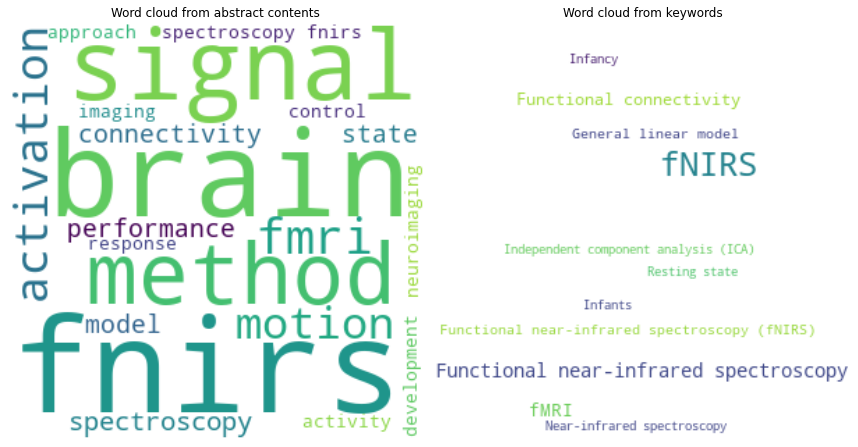

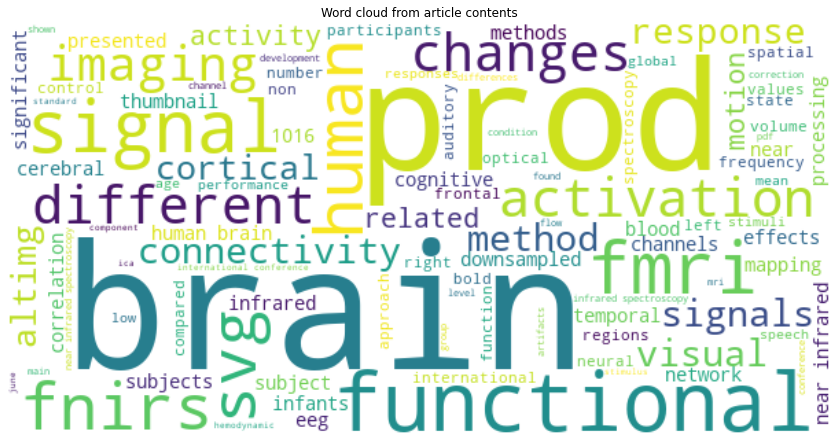

In [776]:
# Generating and showing the word cloud for word text, abstract and keywords
wordcloud_text = WordCloud(width = 600, height = 300, background_color ='white', 
                      contour_width=3, contour_color='steelblue').generate_from_frequencies(text_freq)
wordcloud_abs = WordCloud(width = 300, height = 300, background_color ='white', 
                      contour_width=3, contour_color='steelblue').generate_from_frequencies(abs_freq)
wordcloud_kw = WordCloud(width = 300, height = 300, background_color ='white', 
                      contour_width=3, contour_color='steelblue').generate_from_frequencies(kw_freq)



fig = plt.figure(figsize = (12, 12), facecolor = None)
fig.add_subplot(1,2, 2)  
plt.imshow(wordcloud_kw, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad = 1)
plt.title("Word cloud from keywords")

fig.add_subplot(1, 2, 1)
plt.imshow(wordcloud_abs, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad = 1)
plt.title("Word cloud from abstract contents")

plt.savefig('WordCloud_abs_kw.png', bbox_inches='tight')
            
fig = plt.figure(figsize = (12, 6), facecolor = None) 

plt.imshow(wordcloud_text, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad = 1)
plt.title("Word cloud from article contents")
plt.savefig('WordCloud_text.png', bbox_inches='tight')

Given the similarity in the word cloud extracted from keywords, article content and the abstract, we can be more confident that our count vectorizer model is working as expected.

Now lets compare the prediction scores which we can get with other fNIRS articles, fMRI articles, Pyshcology articles and Geology articles. The expectation is that articles would be in descending order of similarity.

In [777]:
# Lets get the scores for other fNIRS articles
Other_fNIRS_files = glob.glob('data/OtherfNIRS/*.json')
Other_fNIRS_features = pipe.transform(Other_fNIRS_files)

In [778]:
# Lets get the scores for fMRI articles
fMRI_files = glob.glob('data/fMRI/*.json')
fMRI_features = pipe.transform(fMRI_files)

In [779]:
# Lets get the scores for Psychology articles
Psy_files = glob.glob('data/Psychology/*.json')
Psy_features = pipe.transform(Psy_files)

In [780]:
# Lets get the scores for Geology articles
Geo_files = glob.glob('data/Geology/*.json')
Geo_features = pipe.transform(Geo_files)

Lets give some weights to each of the columns as measure of feature importance for our columns [text_cos, abs_cos, kw_cos, ref_cos, std_cite, std_snip, std_sj] which are [0.25 ,0.5, 0.25, 0.25, 0.5, 0.2, 0.2]

In [781]:
fNIRS_scores = fNIRS_features.apply(lambda x: np.dot([0.25 ,0.5, 0.25, 0.25, 0.5, 0.2, 0.2], x[['text_cos', 'abs_cos', 'kw_cos', 'ref_cos', 'std_cite', 'std_snip', 'std_sjr']].values), axis =1)

In [782]:
Other_fNIRS_scores = Other_fNIRS_features.apply(lambda x: np.dot([0.25 ,0.5, 0.25, 0.25, 0.5, 0.2, 0.2], x[['text_cos', 'abs_cos', 'kw_cos', 'ref_cos', 'std_cite', 'std_snip', 'std_sjr']].values), axis =1)

In [783]:
fMRI_scores = fMRI_features.apply(lambda x: np.dot([0.25 ,0.5, 0.25, 0.25, 0.5, 0.2, 0.2], x[['text_cos', 'abs_cos', 'kw_cos', 'ref_cos', 'std_cite', 'std_snip', 'std_sjr']].values), axis =1)

In [784]:
Psy_scores = Psy_features.apply(lambda x: np.dot([0.25 ,0.5, 0.25, 0.25, 0.5, 0.2, 0.2], x[['text_cos', 'abs_cos', 'kw_cos', 'ref_cos', 'std_cite', 'std_snip', 'std_sjr']].values), axis =1)

In [785]:
Geo_scores = Geo_features.apply(lambda x: np.dot([0.25 ,0.5, 0.25, 0.25, 0.5, 0.2, 0.2], x[['text_cos', 'abs_cos', 'kw_cos', 'ref_cos', 'std_cite', 'std_snip', 'std_sjr']].values), axis =1)

<Axes: >

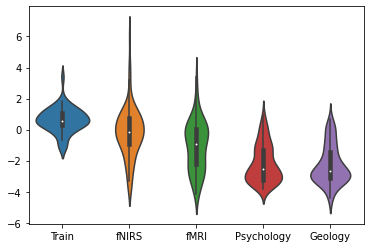

In [786]:
# Lets convert all the scores to a data frame and plot it using Seaborn
df_scores = pd.DataFrame({'Train': fNIRS_scores, 'fNIRS': Other_fNIRS_scores, 
                          'fMRI':fMRI_scores, 'Psychology':Psy_scores, 'Geology': Geo_scores})
sns.violinplot(data=df_scores)

As expected our patterns are followed with fNIRS articles having higher scores compred to fMRI articles and Psychology and Geology articles have very low scores

## Finally lets calculate some scores and make predictions on a bunch of queried articles to see which one we should read next

In [787]:
Test_files = glob.glob('data/Test/*.json')
Test_features = pipe.transform(Test_files)

In [831]:
Test_scores = Test_features.apply(lambda x: np.dot([0.25 ,0.5, 0.25, 0.25, 0.5, 0.2, 0.2], x[['text_cos', 'abs_cos', 'kw_cos', 'ref_cos', 'std_cite', 'std_snip', 'std_sjr']].values), axis =1)

In [832]:
# Creating a table with the doi, title, url and scores of the Test articles
Test_scores = Test_features[['doi', 'title', 'url']].assign(scores = Test_scores )

In [837]:
# Scoring test scores by descending order
Test_scores.sort_values(by=['scores'], ascending = False, inplace = True).reset_index(drop)

In [840]:
# Printing out the scores of the articles in our test data
Test_scores.head()

,doi,title,url,scores
1164,10.1016/j.physrep.2021.03.002,Physical principles of brain–computer interfac...,https://www.sciencedirect.com/science/article/...,6.019839
1236,10.1016/j.tics.2016.03.014,Building a Science of Individual Differences f...,https://www.sciencedirect.com/science/article/...,5.570278
1240,10.1016/j.tics.2019.01.002,Herding Brains: A Core Neural Mechanism for So...,https://www.sciencedirect.com/science/article/...,4.967133
1241,10.1016/j.tics.2020.01.006,Interpersonal Neural Entrainment during Early ...,https://www.sciencedirect.com/science/article/...,4.761584
1049,10.1016/j.neuron.2014.05.001,Discriminative and Affective Touch: Sensing an...,https://www.sciencedirect.com/science/article/...,4.747127


In [930]:
# Asking the user for no of articles to be recommended and then printing the title and the doi
n_rec = input("How many articles do you want recommended: ")
n_rec= int(n_rec)
top  = Test_scores.iloc[:n_rec, :]
print(" Here are your recommendations")
for i, row in top.iterrows():
    print('Article Id: {} Title: {} URL: {}'.format(i, row['title'], row['url']))

How many articles do you want recommended: 19
 Here are your recommendations
Article Id: 1164 Title: Physical principles of brain–computer interfaces and their applications for rehabilitation, robotics and control of human brain states URL: https://www.sciencedirect.com/science/article/pii/S0370157321001095
Article Id: 1236 Title: Building a Science of Individual Differences from fMRI URL: https://www.sciencedirect.com/science/article/pii/S1364661316300079
Article Id: 1240 Title: Herding Brains: A Core Neural Mechanism for Social Alignment URL: https://www.sciencedirect.com/science/article/pii/S1364661319300166
Article Id: 1241 Title: Interpersonal Neural Entrainment during Early Social Interaction URL: https://www.sciencedirect.com/science/article/pii/S1364661320300243
Article Id: 1049 Title: Discriminative and Affective Touch: Sensing and Feeling URL: https://www.sciencedirect.com/science/article/pii/S0896627314003870
Article Id: 1238 Title: Infant fMRI: A Model System for Cognitive 

In [932]:
# Ask the user whether they want any of the articles to be added to the exisiting list of articles
import urllib.parse
import shutil
client.local_dir = article_folder # My data folder file

resp1 = input("Do you want to add any of the articles to your article list? Enter Y or N: ")
if resp1.lower()=='y':
    resp2 = input("Enter the article IDs that you want to be added, seperated by a comma: ")
    articles2add = [int(s.strip()) for s in resp2.split(',')]
    valid = list(set(top.index).intersection(set(articles2add)))
    if len(valid)!= len(articles2add):
        print("Not all valued entered are added. Only adding the valid entries", valid)
    dois2add = top.loc[valid, ['doi', 'title']]
    for i, row in dois2add.iterrows():
        doi = row['doi']
        fname="https://api.elsevier.com/content/article/doi/"+ doi
        fname = urllib.parse.quote(fname, safe='')
        
    # Lets search for the file name in the my article folder if so no transfer is needed.
    # If it is not and transfer it to the articles folder. Although I could simply use
    # the glob file list. In future, i would want a ranking with just the API's so that no local files are stored.
    
        ftransfer = glob.glob(os.path.join(article_folder, fname+'.json'))
        if len(ftransfer)>0:
            print("Article  with title: {}\n Not tranfered as it already exists".format(row['title']))
        else:
            ftransfer = glob.glob('data/Test/'+fname+'.json')
            # If it exists in test then move to my own fNIRS folder
            if len(ftransfer)>0:
                shutil.move(ftransfer[0], article_folder)
                print("Article  with title: {}\n Successfully added".format(row['title']))
            else:
                #If the file is not available we want to use the Scirdirect API to get the file
                doi_doc = FullDoc(doi = d)
                if doi_doc.read(client):
                    doi_doc.write()
                    print ("File: {} successfully transferred".format(doi_doc.title))
                    
                
elif resp1.lower()!='n':
    print('Only Y or N are valid inputs ')
   

Do you want to add any of the articles to your article list? Enter Y or N: Y
Enter the article IDs that you want to be added, seperated by a comma: 1236
Article  with title: Building a Science of Individual Differences from fMRI
 Successfully added


In [933]:
# Retrain model with the updated articles so that our model is not outdated 
resp3 = input("Do you want to retrain the model with the updated articles? ")
if resp3.lower()=='y':
    fNIRS_files = glob.glob(os.path.join(article_folder,'*.json'))
    pipe.fit(fNIRS_files)
elif resp3.lower()!='n':
    print('Only Y or N are valid inputs ')

Do you want to retrain the model with the updated articles?Y


C:\Users\prady\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(
C:\Users\prady\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\prady\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (52). n_quantiles is set to n_samples.
  warnings.warn(
